*Libraries*

In [126]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from pandas.core.common import SettingWithCopyWarning
import warnings

*pandas options*

In [127]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.width', 500)

*reading data*

In [128]:
df_ = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [129]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


*Data Preparation*

In [130]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [131]:
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [132]:
df = df[~df["Invoice"].str.contains("C", na=False)] # deleting canceled transactions

df = df[(df['Quantity'] > 0)]

df = df[(df['Price'] > 0)]

df["TotalPrice"] = df["Quantity"] * df["Price"]

In [133]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom,15.30000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom,22.00000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000


*Calculating RFM Metrics*

In [134]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [135]:
today_date = dt.datetime(2011, 12, 11)


rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days, # recency value
                                     'Invoice': lambda x: x.nunique(),                     # frequency value
                                     'TotalPrice': lambda x: x.sum()})                     # monetary value


rfm.columns = ['recency', 'frequency', 'monetary']

rfm = rfm[(rfm['monetary'] > 0)]

rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.00000,326,1,77183.60000
12347.00000,3,7,4310.00000
12348.00000,76,4,1797.24000
12349.00000,19,1,1757.55000
12350.00000,311,1,334.40000


*Calculating RFM Scores*

In [136]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.00000,326,1,77183.60000,1,1,5,11
12347.00000,3,7,4310.00000,5,5,5,55
12348.00000,76,4,1797.24000,2,4,4,24
12349.00000,19,1,1757.55000,4,1,4,41
12350.00000,311,1,334.40000,1,1,2,11


*Creating & Analysing RFM Segments*

In [137]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [138]:
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [139]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12346.00000,326,1,77183.60000,1,1,5,11,hibernating
12347.00000,3,7,4310.00000,5,5,5,55,champions
12348.00000,76,4,1797.24000,2,4,4,24,at_Risk
12349.00000,19,1,1757.55000,4,1,4,41,promising
12350.00000,311,1,334.40000,1,1,2,11,hibernating


In [140]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency       frequency         monetary      
                         mean count      mean count       mean count
segment                                                             
about_to_sleep       53.31250   352   1.16193   352  471.99437   352
at_Risk             153.78583   593   2.87690   593 1084.53530   593
cant_loose          132.96825    63   8.38095    63 2796.15587    63
champions             6.36177   633  12.41390   633 6857.96392   633
hibernating         217.60504  1071   1.10177  1071  488.64331  1071
loyal_customers      33.60806   819   6.47985   819 2864.24779   819
need_attention       52.42781   187   2.32620   187  897.62786   187
new_customers         7.42857    42   1.00000    42  388.21286    42
potential_loyalists  17.39876   484   2.01033   484 1041.22200   484
promising            23.51064    94   1.00000    94  294.00798    94

# K_MEANS

*Data Scaling*

In [141]:
scaler = MinMaxScaler((0, 1))
scaler.fit_transform(rfm[["recency", "frequency", "monetary"]])

array([[8.71313673e-01, 0.00000000e+00, 2.75443343e-01],
       [5.36193029e-03, 2.88461538e-02, 1.53683623e-02],
       [2.01072386e-01, 1.44230769e-02, 6.40069761e-03],
       ...,
       [1.87667560e-02, 4.80769231e-03, 6.22050635e-04],
       [8.04289544e-03, 7.21153846e-02, 7.46293026e-03],
       [1.12600536e-01, 9.61538462e-03, 6.54359438e-03]])

In [142]:
segment_data = pd.DataFrame(scaler.fit_transform(rfm[["recency", "frequency", "monetary"]]),
                            index=rfm.index, columns=["new_Recency", "new_Frequency", "new_Monetary"])
segment_data.reset_index(inplace=True)
segment_data.head()

,Customer ID,new_Recency,new_Frequency,new_Monetary
0,12346.00000,0.87131,0.00000,0.27544
1,12347.00000,0.00536,0.02885,0.01537
2,12348.00000,0.20107,0.01442,0.00640
3,12349.00000,0.04826,0.00000,0.00626
4,12350.00000,0.83110,0.00000,0.00118


*Determining the Optimum Number of K-Means Clusters*

AttributeError: ignored

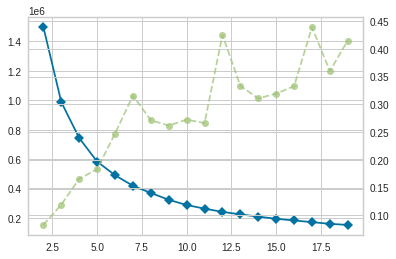

In [143]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(segment_data)
elbow.show()

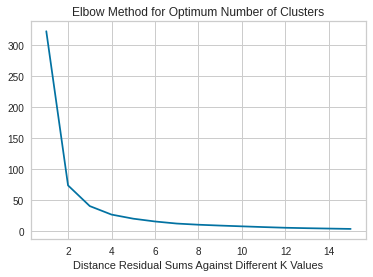

In [144]:
# Manual method for cluster count
segment_data = pd.DataFrame(scaler.fit_transform(rfm[["recency", "frequency", "monetary"]]),
                            index=rfm.index, columns=["Recency_new", "Frequency_new", "Monetary_new"])

kmeans = KMeans()
ssd = []
K = range(1, 16)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(segment_data)
    ssd.append(kmeans.inertia_)

ssd

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums Against Different K Values")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

*Final Model*

In [145]:
kmeans = KMeans(n_clusters=6).fit(segment_data) # kmeans object

In [146]:
segment_data["clusters"] = kmeans.labels_ # created "cluster" column
segment_data.head()

,Recency_new,Frequency_new,Monetary_new,clusters
Customer ID,,,,
12346.00000,0.87131,0.00000,0.27544,4
12347.00000,0.00536,0.02885,0.01537,2
12348.00000,0.20107,0.01442,0.00640,0
12349.00000,0.04826,0.00000,0.00626,2
12350.00000,0.83110,0.00000,0.00118,4


In [147]:
segment_data["clusters"].value_counts() # how many values are there in the clusters

2    2034
0    1034
3     517
1     439
4     290
5      24
Name: clusters, dtype: int64

In [148]:
clusters = kmeans.labels_

pd.DataFrame({"CustomerID": segment_data.index, "Clusters": clusters}).head(10)

,CustomerID,Clusters
0,12346.00000,4
1,12347.00000,2
2,12348.00000,0
3,12349.00000,2
4,12350.00000,4
5,12352.00000,2
6,12353.00000,1
7,12354.00000,1
8,12355.00000,1
9,12356.00000,2


In [149]:
segmentation = rfm.merge(segment_data, on = "Customer ID")
segmentation.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,Recency_new,Frequency_new,Monetary_new,clusters
Customer ID,,,,,,,,,,,,
12346.00000,326,1,77183.60000,1,1,5,11,hibernating,0.87131,0.00000,0.27544,4
12347.00000,3,7,4310.00000,5,5,5,55,champions,0.00536,0.02885,0.01537,2
12348.00000,76,4,1797.24000,2,4,4,24,at_Risk,0.20107,0.01442,0.00640,0
12349.00000,19,1,1757.55000,4,1,4,41,promising,0.04826,0.00000,0.00626,2
12350.00000,311,1,334.40000,1,1,2,11,hibernating,0.83110,0.00000,0.00118,4
